# Imports


In [4]:
#!/usr/bin/env python
# coding: utf-8

# # LPDA trigger threshold

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import  DateFormatter

from NuRadioReco.modules.trigger import powerIntegration
from NuRadioReco.modules.channelBandPassFilter import channelBandPassFilter
from NuRadioReco.modules.io.rno_g import readRNOGData
from NuRadioReco.detector import detector
from NuRadioReco.utilities import units

import uproot
from astropy.time import Time, TimeDelta

#disable trigger overridden warning
import logging
logging.getLogger('BaseStation').setLevel(logging.ERROR)

from tensorflow import keras

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob, os
import sys

sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("analyze.py"))))
sys.path.insert(1, '/lustre/fs22/group/radio/dhjelm/')
import data_preprocessing
import analyze

# WGAN

In [15]:
dataset = np.load('/lustre/fs22/group/radio/dhjelm/data.npy')
data = np.load('/lustre/fs22/group/radio/dhjelm/data_preprocessed.npy')
print(type(data))

<class 'numpy.ndarray'>


In [5]:
generator = keras.models.load_model('time_fft_wavelet_generator_2')

2022-09-22 15:46:27.349374: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-22 15:46:27.349424: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-22 15:46:27.349454: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (wgs3e.zeuthen.desy.de): /proc/driver/nvidia/version does not exist
2022-09-22 15:46:27.349833: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
def get_generated_noise(generator):
    input_noise = np.random.randn(1, 128)
    input_noise = np.expand_dims(input_noise, axis=-1) 
    noise = generator.predict_on_batch(input_noise)
    noise = noise[:,:,0]
    noise = noise*dataset.std() + dataset.mean()
    return noise[0]

In [5]:
# Save original directory
owd = os.getcwd()

In [6]:

# Station to pick files from
station = 24

# Change to the data directory
os.chdir("../../shallman/data/rno_g/forced_triggers/inbox/")

# Create a list for file names
file_names = []

# For each root-file in the directory
for file in glob.glob("*.root"):

    # If it belongs to the station
    if file.startswith(f"forced_triggers_station{station}"):

        file_names.append(file)

In [8]:
print(len(file_names))

496


In [9]:

# detector
det = detector.Detector(json_filename="RNO_G/RNO_season_2021.json", antenna_by_depth=False)

# RNOG data reader
reader = readRNOGData.readRNOGData()

# Power integration trigger (since diode is supposed to be ~ power)
trigger = powerIntegration.triggerSimulator()
trigger.begin()

# trigger path, has a ~11 ns integration and bandpass
trigger_integration_window = 11 * units.ns
trigger_passband = [80*units.MHz, 180*units.MHz]
bandpass = channelBandPassFilter()

# test threshold range
thresholds= np.logspace(-4,-2,200)[::-1]


results = []

# which channels to trigger on
surface_channel = 13 #[12,13,14,15,16,17,18,19,20]

# dummy_file = "../../shallman/data/rno_g/forced_triggers/inbox/forced_triggers_station24_run117.root"



for rf_i, run_file in enumerate(file_names):
    reader.begin(run_file)
    for i, event in enumerate(reader.run()):
        
        # Data
        station = event.get_station(event.get_station_ids()[0])
        if not station.get_trigger('force_trigger').has_triggered():
            print("I am here")
            continue
        channel = station.get_channel(surface_channel)
        trace = channel.get_trace()[0:512]
        channel.set_trace(trace, 3.2*units.GHz)
        station.add_channel(channel)
        
        bandpass.run(event, station, det, passband=trigger_passband,
                     filter_type='butter', order=10, rp=None)
    
        triggered_any = False
        triggered_threshold_any = 0
        
        for threshold in thresholds:
            if not triggered_any:
                trigger.run(event, station, det, threshold=threshold,
                        integration_window=trigger_integration_window,
                        triggered_channels=[surface_channel],
                        trigger_name="power_integration_trigger")
                tt = station.get_trigger('power_integration_trigger')
                # set to triggered
                triggered_any = tt.has_triggered()
                if tt.has_triggered():
                    triggered_threshold_any = threshold
            else:
                break
            
        # Generated
        station = event.get_station(event.get_station_ids()[0])
        channel = station.get_channel(surface_channel)
        gen_trace = get_generated_noise()/1000
        channel.set_trace(gen_trace, 3.2*units.GHz)
        station.add_channel(channel)
        
        bandpass.run(event, station, det, passband=trigger_passband,
                     filter_type='butter', order=10, rp=None)
    
        triggered_any_gen = False
        triggered_threshold_gen = 0
        
        for threshold in thresholds:
            if not triggered_any_gen:
                trigger.run(event, station, det, threshold=threshold,
                        integration_window=trigger_integration_window,
                        triggered_channels=[surface_channel],
                        trigger_name="power_integration_trigger")
                tt = station.get_trigger('power_integration_trigger')
                # set to triggered
                triggered_any_gen = tt.has_triggered()
                if tt.has_triggered():
                    triggered_threshold_gen = threshold
            else:
                break
        
        
        
        print(f"Data event {i}, triggered at threshold {triggered_threshold_any}")
        print(f"Generated event {i}, triggered at threshold {triggered_threshold_gen}")
        result = {"station_number": event.get_station_ids()[0],
              "run_number": event.get_run_number(),
              "event_number": event.get_id(),
              "event_i": i,
              "threshold": triggered_threshold_any, "threshold_generator": triggered_threshold_gen,
              "triggered": triggered_any}
        results.append(result)
        
# Go back to original directory
os.chdir(owd)
df = pd.DataFrame(results)
df.to_hdf("trigger_threshold_scan.hdf5", "data")


Data event 0, triggered at threshold 0.0019338917504552321
Generated event 0, triggered at threshold 0.0012458833642950082


2022-09-22 13:09:29.704903: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled


Data event 1, triggered at threshold 0.0015702901247293774
Generated event 1, triggered at threshold 0.0016070528182616384
Data event 2, triggered at threshold 0.000860346441668451
Generated event 2, triggered at threshold 0.0013667163564620073
Data event 3, triggered at threshold 0.0012750512407130128
Generated event 3, triggered at threshold 0.0018896523396912095
Data event 4, triggered at threshold 0.001011637979766207
Generated event 4, triggered at threshold 0.0016831803533309566
Data event 5, triggered at threshold 0.0016831803533309566
Generated event 5, triggered at threshold 0.0014992684327860455
Data event 6, triggered at threshold 0.0011623224686798518
Generated event 6, triggered at threshold 0.0018041864093920718


2022-09-22 13:09:39.621639: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled


Data event 7, triggered at threshold 0.0007488103857590023
Generated event 7, triggered at threshold 0.0016070528182616384


2022-09-22 13:09:41.146511: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled


Data event 8, triggered at threshold 0.002381685551976158
Generated event 8, triggered at threshold 0.0011623224686798518
Data event 9, triggered at threshold 0.0027364399970746718
Generated event 9, triggered at threshold 0.0012458833642950082
Data event 10, triggered at threshold 0.0022739657523579274
Generated event 10, triggered at threshold 0.0015702901247293774


2022-09-22 13:09:46.291603: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled


Data event 11, triggered at threshold 0.0013987131026472386
Generated event 11, triggered at threshold 0.0006669919663030121
Data event 12, triggered at threshold 0.002221946860939524
Generated event 12, triggered at threshold 0.0019338917504552321
Data event 13, triggered at threshold 0.001135733358343105
Generated event 13, triggered at threshold 0.0012458833642950082
Data event 14, triggered at threshold 0.0014314589375234786
Generated event 14, triggered at threshold 0.003072112998861759
Data event 15, triggered at threshold 0.0026738416158399465
Generated event 15, triggered at threshold 0.0008804883581643465


2022-09-22 13:09:55.602308: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled


Data event 16, triggered at threshold 0.0014992684327860455
Generated event 16, triggered at threshold 0.0022739657523579274


2022-09-22 13:09:57.993720: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled


Data event 17, triggered at threshold 0.0011895340673703195
Generated event 17, triggered at threshold 0.0015702901247293774


2022-09-22 13:10:00.554493: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled


Data event 18, triggered at threshold 0.0011623224686798518
Generated event 18, triggered at threshold 0.0009011018251665018


Data event 0, triggered at threshold 0.0005805225516094895
Generated event 0, triggered at threshold 0.001135733358343105


2022-09-22 13:10:08.652219: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled


Data event 1, triggered at threshold 0.0012750512407130128
Generated event 1, triggered at threshold 0.0010843659686896108
Data event 2, triggered at threshold 0.0011895340673703195
Generated event 2, triggered at threshold 0.002171117945694505


2022-09-22 13:10:11.426464: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled


Data event 3, triggered at threshold 0.0016446761779946627
Generated event 3, triggered at threshold 0.00212145178491063
Data event 4, triggered at threshold 0.0012458833642950082
Generated event 4, triggered at threshold 0.0014992684327860455
Data event 5, triggered at threshold 0.0016070528182616384
Generated event 5, triggered at threshold 0.0010353218432956617
Data event 6, triggered at threshold 0.0010353218432956617
Generated event 6, triggered at threshold 0.0008026433522257174


2022-09-22 13:10:19.218962: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled


Data event 7, triggered at threshold 0.0024945081352303164
Generated event 7, triggered at threshold 0.0018041864093920718


2022-09-22 13:10:20.594783: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled


Data event 8, triggered at threshold 0.0016446761779946627
Generated event 8, triggered at threshold 0.001762914118095948
Data event 9, triggered at threshold 0.0019338917504552321
Generated event 9, triggered at threshold 0.0025529080682395165
Data event 10, triggered at threshold 0.0013049019780144017
Generated event 10, triggered at threshold 0.0009221978823334322
Data event 11, triggered at threshold 0.002221946860939524
Generated event 11, triggered at threshold 0.0016831803533309566
Data event 12, triggered at threshold 0.0010843659686896108
Generated event 12, triggered at threshold 0.0015702901247293774
Data event 13, triggered at threshold 0.0009437878277775381
Generated event 13, triggered at threshold 0.00212145178491063


2022-09-22 13:10:31.565049: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled


Data event 14, triggered at threshold 0.0008214343584919422
Generated event 14, triggered at threshold 0.002381685551976158
Data event 15, triggered at threshold 0.0015702901247293774
Generated event 15, triggered at threshold 0.0012750512407130128


2022-09-22 13:10:34.954534: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled


Data event 16, triggered at threshold 0.0018041864093920718
Generated event 16, triggered at threshold 0.0013987131026472386


KeyboardInterrupt: 

In [10]:
data = pd.read_hdf("trigger_threshold_scan.hdf5")

thresholds = np.logspace(-4,-2,200)

n_triggers = np.zeros_like(thresholds)
n_triggers_gen = np.zeros_like(thresholds)

for i, thres in enumerate(thresholds):
    n_triggers[i] = np.sum(data.threshold>thres)
    n_triggers_gen[i] = np.sum(data.threshold_generator>thres)


trace_length = 512
sampling_rate_ghz = 3.2
plt.plot(thresholds, n_triggers/len(data.threshold), label = "Data")
plt.plot(thresholds, n_triggers_gen/len(data.threshold_generator), label = "Generated")
plt.xlabel("Trigger threshold")
plt.ylabel("Triggered event fraction")
plt.legend()
plt.semilogx()

FileNotFoundError: File trigger_threshold_scan.hdf5 does not exist

In [9]:
noise = np.random.randn(len(data), 128)
noise = np.expand_dims(noise, axis=-1) 
generated_signals = generator.predict_on_batch(noise)
generated_signals = generated_signals[:,:,0]

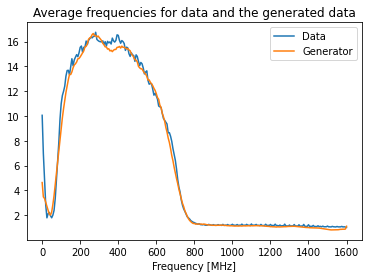

In [12]:
analyze.avg_frequencies(data, generated_signals)

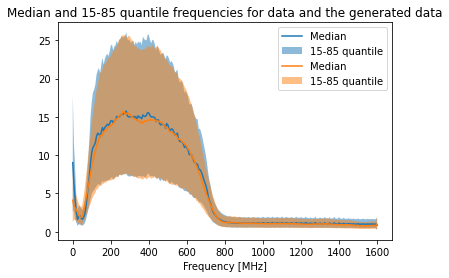

In [13]:
analyze.quantile_frequencies(data, generated_signals)